### Python Modules used in Project

In [31]:
import cv2
import numpy as np
import os
import cvlib as cv
import random 
import math
import requests
import uuid
import matplotlib.pyplot as plt
from datetime import datetime
from cvlib.object_detection import draw_bbox
from skimage import img_as_ubyte as im2uint8
from skimage import img_as_float64 as im2double
from skimage.color import rgb2hsv,hsv2rgb
import time

### Function to rescale image to a new range (min -> max)

In [32]:
def rescale(img,min,max):
    return np.interp(img, (img.min(), img.max()), (min, max))

### Function to apply log transformation on input image 

In [33]:
#log transformation
def logtransform(image,c):
    image = c * np.log (1 + image)
    return image

### Function to Sharpen an image using unsharp masking

In [34]:
#unsharp_masking
def unsharpmasking(image,size):
    #declaring 7*7 averaging filter
    filter = np.ones((size,size)) / (size**2) 
    #apply filter on image to blur 
    blurred = cv2.filter2D(image,-1,filter)
    blurred = im2double(blurred)
    #extract edges by subtracting blurred image from original 
    edges = image - blurred
    edges = im2uint8(edges)
    #converting original image to uint8
    image = im2uint8(image)
    #adding edges to original image to sharpen (image + edges)
    
    temp = 255 - edges
    np.putmask(image ,temp < image , temp)
    image += edges
    
    #returning sharpened image 
    return image

### Following function enhances the  provided image for better object detection 

In [35]:
def enhance_image(img):
    [r,c,p] = img.shape
    # RGB -> HSV 
    hsv_img = rgb2hsv(img)
    # Extracting Intensity Plane
    intensity_plane  = hsv_img[:,:,2]
    # Rescale Intensity plane to overcome brighter pixels
    intensity_plane = rescale(intensity_plane,0,0.8)
    # Apply log transformation to expand dark regions for c = 1.5
    intensity_plane = logtransform(intensity_plane,1.5)
    #Apply unsharpmasking to sharpen image using filter 7*7
    intensity_plane = unsharpmasking(intensity_plane,7)
    
    #creating new hsv image and appending enhanced intencity plane to it 
    new_hsv_img = np.ones((r,c,p) )
    intensity_plane = im2double(intensity_plane)
    new_hsv_img[:,:,0] = hsv_img[:,:,0]
    new_hsv_img[:,:,1] = hsv_img[:,:,1]
    new_hsv_img[:,:,2] = intensity_plane
    
    #converting enhanced HSV to RGB  
    new_rgb = hsv2rgb(new_hsv_img)
    R = new_rgb[:,:,0]
    G = new_rgb[:,:,1]
    B = new_rgb[:,:,2]
    
    #Taking negative of RGB image 
    R = 255 - R
    G = 255 - G
    B = 255 - B

    #Creating new RGB image with negative values  
    new_img = np.zeros((r,c,3))
    new_img[:,:,0] = R
    new_img[:,:,1] = G
    new_img[:,:,2] = B
    
    #rescaling new RGB to range 0-1 for conversion purpose 
    new_img = rescale(new_img,0,1)
    
    #converting image to uint8
    new_img = im2uint8(new_img)
    
    return new_img

### Following function applies image enhancement of a image list (input) 

In [36]:
#applies image enhancement on arary of images and return enhanced images
def apply_enhancement(data):
    enhanced_data = []
    for img in data:
        enhanced_data.append(enhance_image(img))
    return enhanced_data    

### Image Acquisition

In [37]:
def get_images(path):            #takes random images from specified directory
    data = []
    img_paths =[] 
    dirs  = os.listdir(path)
    random.shuffle(dirs)
    for k, v in enumerate(dirs[:4]):
            img_paths.append(path+'/'+v)
            img = plt.imread(path+'/'+v)
            data.append(img)  
     #returning image paths and data array.       
    return data,img_paths

### Following function plots images provided as input in a subplot

In [38]:
def printimages(data,title='images',vehicles=None):     #print images set in a subplot
    x = len(data);
    fig, _ = plt.subplots(math.ceil(x/2),2)  #specifies 2 images per row
    fig.suptitle(title)
    fig.set_size_inches(18, 18)

    dirs  = os.listdir(path)
    random.shuffle(dirs)
    for k, v in enumerate(data):
            plt.subplot(math.ceil(x/2),2, k+1)
            plt.axis('off')
            plt.imshow(v)
            if vehicles:               #if no. of vehicles is passed display them on images 
                plt.text(8, 8, "no of vehicles: "+ str(vehicles[k]), bbox=dict( edgecolor='black', linewidth=3),fontsize='x-large')
    plt.show()

### Following function applies image detection on provided images list and returns detected images and densities

In [39]:
def detect_vehicles(data):                                                            #detect  vehicles in provided images
    detected_imgs = []
    densities = []
    for img in data:
        new_img = enhance_image(img)
        
        # applying detection on both enhanced and unenhanced images to get best results 
        
        bbox, label, conf = cv.detect_common_objects(img)
        bbox2, label2, conf2 = cv.detect_common_objects(new_img)
        vehicles = label.count('car')+label.count('truck')+label.count('motorcycle')+label.count('bus')
        vehicles2 = label2.count('car')+label2.count('truck')+label2.count('motorcycle')+label2.count('bus')
        
        #if enhanced image has more no. of detected images.
        if vehicles > vehicles2:
            output_image = draw_bbox(img, bbox, label, conf)
            densities.append(vehicles)
        else:
            output_image = draw_bbox(img, bbox2, label2, conf2)
            densities.append(vehicles2)  
            
        detected_imgs.append(output_image)
        
    return detected_imgs,densities

### Following function return a priority queue of traffic densities

In [40]:
def get_priority_queue(densities):
    density_queue = densities[:]
    queue = []
    for x in density_queue:
            max_val = max(density_queue)
            max_index = density_queue.index(max_val)
            queue.append(max_index)
            density_queue[max_index] = -1;
    return queue

### Following function integrates all above function and apply on data 

In [41]:
def signal_controller():
    data = get_images(os.getcwd() +'/traffic-data/')
    img_paths = data[1]
    data = data[0]
#     data  = apply_enhancement(data)
    detected_data = data[:]
    detection = detect_vehicles(detected_data);                  #Object Detection
    detected_data = detection[0]                  #Object Detection
    img_densities = detection[1]          #Vehicle Counting
    priority_queue = get_priority_queue(img_densities)  #priority queue based on densities of images
    return priority_queue,img_paths,detected_data,img_densities

### Basic Algorithm to handle signal lights based on traffic

In [42]:
def signal_shifter():
    while 1 :
        id = str(uuid.uuid4())
        global streak,control
        controller = signal_controller()
        img_paths  = controller[1]
        priority_index = controller[0][0]
        if streak < 3  and control == priority_index:
            streak += 1
#             print("streak for light:"+str(control)+" is "+str(streak))
        elif(streak==3):
            control = controller[0][1]
            streak = 0
#             print("traffic_light :"+str(control))
        else:
             control = priority_index
#              print("traffic_light :"+str(control))
             streak = 0   
        obj = {"id":id,"time_stamp":str(datetime.now()),"images":img_paths,"control":control,"streak":streak}
        url = "http://localhost:8000/signals"
        x = requests.post(url,data = obj)
        print(x.text)

### TESTING

['/home/anonymous/jupyter notebooks/python/traffic-data//48.jpg', '/home/anonymous/jupyter notebooks/python/traffic-data//212.jpg', '/home/anonymous/jupyter notebooks/python/traffic-data//251.jpg', '/home/anonymous/jupyter notebooks/python/traffic-data//504.jpg']


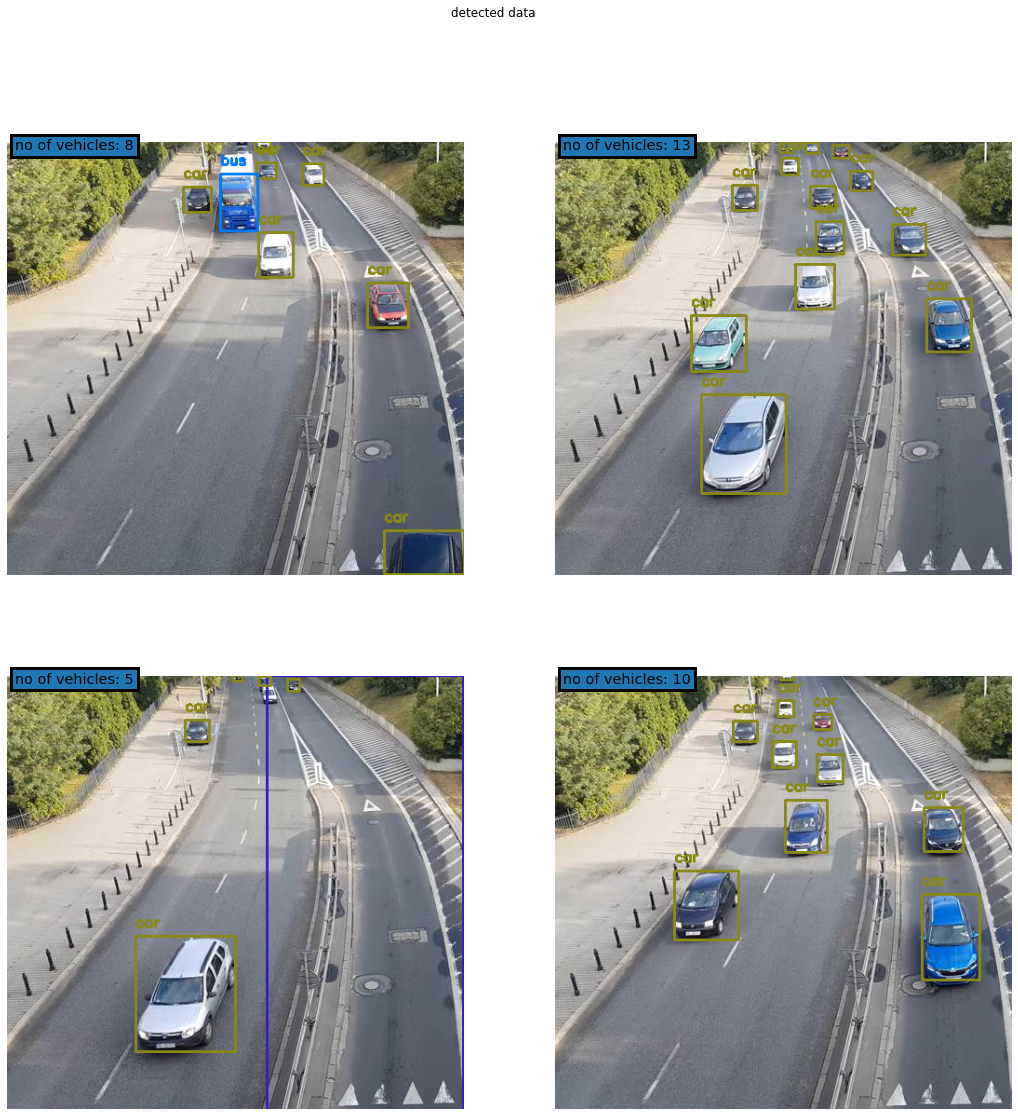

In [43]:
controller = signal_controller()
paths = controller[1]
detected_images = controller[2]
intensities = controller[3]
print(paths)
printimages(detected_images,'detected data',intensities);

### Running program recursively and post data on API

In [44]:
# setting globals 
control = -1
streak = 0

signal_shifter()

{
  "id": "d3815bb9-2553-47ff-bae2-01e1ff855ba1",
  "time_stamp": "2021-06-07 10:14:51.869812",
  "images": [
    "/home/anonymous/jupyter notebooks/python/traffic-data//402.jpg",
    "/home/anonymous/jupyter notebooks/python/traffic-data//243.jpg",
    "/home/anonymous/jupyter notebooks/python/traffic-data//486.jpg",
    "/home/anonymous/jupyter notebooks/python/traffic-data//429.jpg"
  ],
  "control": "0",
  "streak": "0"
}
{
  "id": "9e222d50-0ab9-454e-8214-415ef55a0e43",
  "time_stamp": "2021-06-07 10:15:02.750024",
  "images": [
    "/home/anonymous/jupyter notebooks/python/traffic-data//545.jpg",
    "/home/anonymous/jupyter notebooks/python/traffic-data//438.jpg",
    "/home/anonymous/jupyter notebooks/python/traffic-data//301.jpg",
    "/home/anonymous/jupyter notebooks/python/traffic-data//127.jpg"
  ],
  "control": "2",
  "streak": "0"
}
{
  "id": "e5edd615-0f36-44b8-8162-620a52fffeb4",
  "time_stamp": "2021-06-07 10:15:13.837371",
  "images": [
    "/home/anonymous/jupyter n

KeyboardInterrupt: 